In [1]:
# Необходмые команды импорта.
import sys
#import os
sys.path.append('../physlearn/')
sys.path.append('../source')
import numpy as np
from numpy import linalg as LA
import tensorflow as tf
from matplotlib import pylab as plt
from IPython.display import clear_output
from physlearn.NeuralNet.NeuralNet import NeuralNet
from physlearn.Optimizer.NelderMead.NelderMead import NelderMead
from ann_solver import AnnSolver
import d1_osc
import ann_constructor
import math_util
from visualiser import Visualiser

# Model Parameters
n_hid1 = 12
m = 350 # размер сеток обучения
M = 4 # количество выходных нейронов(базисных функций)
a = -10
b = 10
n_hid2 = 12
%matplotlib inline

# ANN
net, net_output, net_sum, sess = ann_constructor.return_separated_deep_net_expressions(M, n_hid1, n_hid2)
# Выражение, определяющеие образ выходов сети при действии гамильтонианом. Task-dependant
dim = net.return_unroll_dim()
print(dim)

solver = AnnSolver(ann = net, ground_method='gaus')
solver.define_approximation_grid(a, b, m)
solver.define_linearity_grid(M)
solver.compile()
J = solver.get_cost_func()

trial_func = solver.get_trial_func()
func_sum = tf.reduce_sum(input_tensor=trial_func, axis=0)
images = solver.get_images()
images_sum = tf.reduce_sum(input_tensor=images, axis=0)


# Оптимизация
opt_nm = NelderMead(-2.5,2.5)
opt_nm.set_epsilon_and_sd(0.3, 100)

def opt(J, dim, n_it, eps):
    optimisation_result = opt_nm.optimize(J, dim+1, n_it, eps)
    return optimisation_result

D:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


772


In [10]:
optimisation_result = opt(J, dim, int(3e6), 1e-3)
print("J after optimisation: ", J(optimisation_result.x))
print("Информация: ", optimisation_result)

...  413410 (13%) 168.723 it\s

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

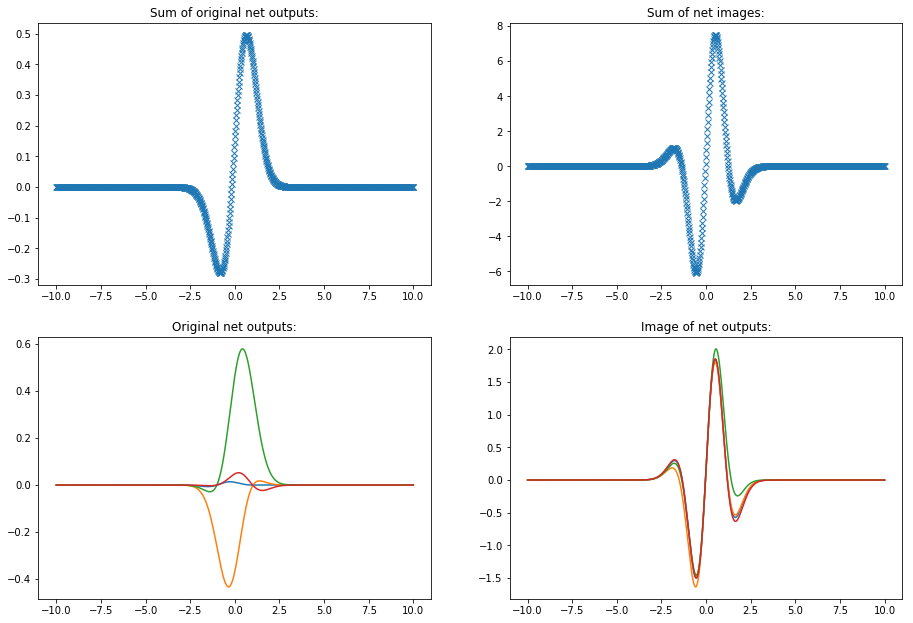

In [11]:
xi_obs = np.linspace(a, b, 1000, endpoint=True)
vis = Visualiser(solver)
vis.plot_four(xi_obs.reshape(1, 1000))

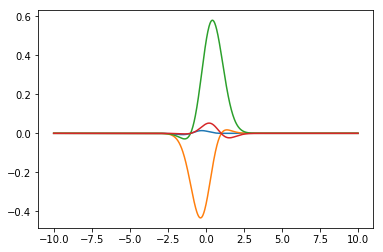

In [12]:
y1 = net.calc(trial_func, {net.x : xi_obs.reshape(1, 1000)})
for i in range(M):
    func_i = y1[i,:]
    plt.plot(xi_obs.reshape(1, 1000)[0], func_i)

[-1.68432785+0.j  0.35856943+0.j -0.00436998+0.j  0.00865222+0.j]


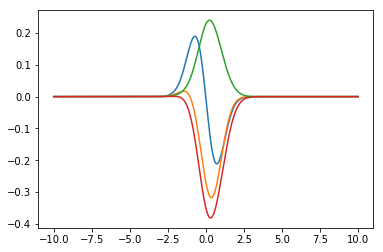

In [24]:
from scipy.linalg import eig
#coll_grid = np.linspace(-2,2,M).reshape(1, M)
coll_grid = math_util.calc_hermite_grid_xi(M).reshape(1, M)
ham_matrix = net.calc(images, {net.x:coll_grid})
eigvals, eigvecs = eig(ham_matrix)
print(eigvals)
func_matrix = net.calc(trial_func, {net.x:xi_obs.reshape(1, 1000)})
for i in range(M):
    y = np.matmul(np.transpose(func_matrix), eigvecs[:,i])
    plt.plot(xi_obs, y)

In [39]:
def calc_i_eigfunc(i, x_in):
    func_matrix = net.calc(trial_func, {net.x:x_in.reshape(1, 1000)})
    return np.matmul(np.transpose(func_matrix), eigvecs[:,i])

def show_i_eigfunc(i, x_in):
    plt.plot(x_in, calc_i_eigfunc(i, x_in))

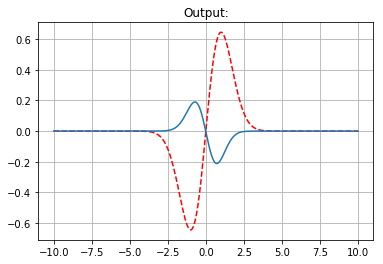

In [41]:
d1_osc.show_wf(1, xi_obs.reshape(1, 1000))
show_i_eigfunc(0, xi_obs)

In [33]:

y_true = d1_osc.wf(1, xi_obs)
y_hyp = calc_i_eigfunc(0, xi_obs)
print(y_true.shape, ' ', y_hyp.shape)
print(y_true/ y_hyp))

(1000,)   (1000,)
5.0497304808438054e+25
